

## Intro

___


Suppose you have a collection of states ${s_1,...,s_n}$. We're going to denote the probabaility of $s_i$ moving to $s_j$ as given by $p_{i,j}$. The states can really be anything, for instance they could encode letters and the probabailties $p_{a, b}$ would be the probabilty for finding the letters 'a' and 'b' next to each other in a sentance. 

I'm going to represent three objects of interest using classes. 

1. The first is a walker class. We're going to use this to generate random walks from the graph. It stores only a single state so for instance perhaps the letter 'l'. 
2. The next is called State and represents distrubutions of walkers. So picture each walker as an individual in a population. Suppose for this popultaion 50% of the walker individuals are sat on the letter 'l' then we represent that by setting the dictionary value for 'l' to 0.5. This is a vector representation of how things, in this case our walkers, are distrubuted across the network. 
3. The transistion Matrix class encodes the probabailiies of transistions in states.  So exactly the $p_{i,j}$ above. In this case we're looking at transistions between letters. This class acts on each of the above objects in predicatble ways. 
    - In the first case a tansition matrix applied to a walker will update the state of the walker to a new state dependent on the trasnition probabilities. So if the walker is sitting in the 'l' state and $p_{l,o}=0.25$, $p_{l,s}=0.25$ and $p_{l,t}=0.5$ then 'l' is going to move to t half of the time and 'o' and 's' 25 percent of the time. 
    - In the second T is going to evolve the distrubution of states in proportion to the transistion probabailities. so suppse half of your walkers are hanging around on 'l' and the other half are hanging around on 't'. Suppose $p_{l,s}=0.7$ and $p_{t,s}=0.3$ then we calculate the probortion of walkers that will step from 'l' to 's' or 't' to 's' by: $$0.5 \times p_{l,s} + 0.5 \times p_{t,s} = 0.5 \times 0.7 + 0.5 \times 0.3 = 0.5 $$ So this would mean half the population of walkers end up stat on 's' after one time step.
    In the case of applying the transistion Matrix to a State we are evolving the probabailities of walkers being in a particular states. In the case of applying the transistion Matrix to a Walker we are sampling the orbit such a walker might take.


In [98]:
from itertools import tee
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import math

# For generating pairwise elements in a list. [1,2,3,4,5] becomes (1,2), (2,3), (3,4), (4,5)
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

# For running random walks on the graph
class Walker:
    def __init__(self, state):
        self.state = state


# Abstaction of single state such as in the Walker class to a distrubution of states.
class State:
    def __init__(self, states):
        self.states = {state: 0  for state in states}
        
    def __str__(self):
        string = ''
        count = 0
        print('-------------------------------------------------------------------------------')
        for i, k in self.states.items():
            count = count + 1
            string = string + '{}  :  {:.5f}  |  '.format(i, k)
            if count > 5:
                string = string + '\n'
                count = 0.
        return string
    
    def draw(self):
        objects = self.states.keys()
        y_pos = np.arange(len(objects))
        performance = [val for k, val in self.states.items()]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, objects)
        plt.ylabel('density')
        plt.title('Word occurence orbit frequency')
        plt.show()
    
    @classmethod
    def from_orbit(cls, orbit):
        instance = cls(orbit)
        for point in orbit:
            instance.states[point] = instance.states.get(point, 0) + 1
        for key, value in instance.states.items():
            instance.states[key] = instance.states[key]/len(orbit) 
        return instance

    @classmethod
    def from_uniform(cls, states):
        instance = cls(states)
        for key, value in instance.states.items():
            instance.states[key] = 1/len(instance.states) 
        return instance

    
    def __sub__(self, other):
        difference = State(self.states.keys())
        for key, _ in difference.states.items():
            difference.states[key] = abs(self.states.get(key, 0) - other.states.get(key, 0))
        return difference
    
    def dist(self, other):
        diff = other - self
        return math.sqrt(sum([v**2 for _, v in diff.states.items()]))

# Going to map between states with this class
class TransitionMatrix:
    def __init__(self, states, data=None):
        self.p = {state: {} for state in states}
        if data is None:
            data = states
        self._count(data)
        self._normalize()

    def _count(self, states):
        for letter_1, letter_2 in pairwise(states):
            self.p[letter_1][letter_2] = self.p[letter_1].get(letter_2, 0) + 1
        
    def _normalize(self):
        for key, val in self.p.items():
            row_total = sum([count for _, count in val.items()])
            for target, count in val.items():
                self.p[key][target] = self.p[key][target]/row_total
            
    # computes transpose
    def T(self):
        newt = TransitionMatrix([state for state, _ in self.p.items()], data=[])
        for s_1, P in self.p.items():
            for s_2, p in P.items():
                newt.p[s_2][s_1] = p
        return newt
        
    def __matmul__(self, other):
        """If applying the transistion matrix class to a Walker class then select the next state at random. 
        If applying to a State class we generate a new distrbution. """

        if isinstance(other, State):
            new_state = State([s for s, _ in other.states.items()])
            for s_1, p in other.states.items():
                sum_p_s2_s1 = 0
                for s_2, P in self.p.items():
                    sum_p_s2_s1 = sum_p_s2_s1 + other.states[s_2]*P.get(s_1, 0)
                new_state.states[s_1] = sum_p_s2_s1 
            return new_state

        if isinstance(other, Walker):
            ps = self.p[other.state]
            choices = [*ps.keys()]
            weights = [*ps.values()]
            choice = random.choices(choices, weights=weights).pop()
            return Walker(choice)
    


## Creating A Transistion Matrix

___

So i'm going to get the transistion matrix associated to the letter pairs in the above introduction. The class essentially counts through each adjacent pair of letters and records the frequencies they occur. It then normalizes these frequencys so that given a state the sum of probabailties for transitions to each other state from that state is 1.

In [99]:
import re

intro = """## Intro 
So this is going to try and explain how the metropolis hastings algorithm can be used to sample unbiased samples from networks. We're assuming that we can't just draw samples from the population directly which is often the case. For instance the twitter api doesn't expose a representative sample endpoint for there users. Suppose you have a collection of states ${s_1,...,s_n}$. We're going to denote the probabaility of $s_i$ moving to $s_j$ as given by $p_{i,j}$. The states can really be anything, for instance they could encode letters and the probabailties $p_{a, b}$ would be the probabilty for finding the letters 'a' and 'b' next to each other in a sentance. I'm going to represent three objects of interest using classes. 
1. The first is a walker class. We're going to use this to generate random walks from the graph. It stores only a single state so for instance perhaps the letter 'l'. 
2. The next is called State and represents distrubutions of walkers. So picture each walker as an individual in a population. Suppose for this popultaion 50% of the walker individuals are sat on the letter 'l' then we represent that by setting the dictionary value for 'l' to 0.5. This is a vector representation of how things, in this case our walkers, are distrubuted across the network. 
3. The transistion Matrix class encodes the probabailiies of transistions in states.  So exactly the $p_{i,j}$ above. In this case we're looking at transistions between letters. This class acts on each of the above objects in predicatble ways. 
    - In the first case a tansition matrix applied to a walker will update the state of the walker to a new state dependent on the trasnition probabilities. So if the walker is sitting in the 'l' state and $p_{l,o}=0.25$, $p_{l,s}=0.25$ and $p_{l,t}=0.5$ then 'l' is going to move to t half of the time and 'o' and 's' 25 percent of the time. 
    - In the second T is going to evolve the distrubution of states in proportion to the transistion probabailities. so suppse half of your walkers are hanging around on 'l' and the other half are hanging around on 't'. Suppose $p_{l,s}=0.7$ and $p_{t,s}=0.3$ then we calculate the probortion of walkers that will step from 'l' to 's' or 't' to 's' by: $$0.5 \times p_{l,s} + 0.5 \times p_{t,s} = 0.5 \times 0.7 + 0.5 \times 0.3 = 0.5 $$ So this would mean half the population of walkers end up stat on 's' after one time step.
    In the case of applying the transistion Matrix to a State we are evolving the probabailities of walkers being in a particular states. In the case of applying the transistion Matrix to a Walker we are sampling the orbit such a walker might take.
"""

cleaned_intro = re.sub(r'\W+', '', intro)

T = TransitionMatrix(cleaned_intro)


So now we can see which letters can go to which other letters and how likely they are to do so. We just look at `T.p['u']`.

In [100]:
T.p['u']

{'s': 0.13157894736842105,
 'n': 0.07894736842105263,
 'm': 0.02631578947368421,
 'l': 0.23684210526315788,
 'p': 0.15789473684210525,
 'h': 0.02631578947368421,
 'b': 0.07894736842105263,
 't': 0.07894736842105263,
 'r': 0.07894736842105263,
 'a': 0.05263157894736842,
 'e': 0.02631578947368421,
 'c': 0.02631578947368421}

We can verify the sum of these values is 1. Becuase this is a descrete probabaility distrubution we require that these values sums to one. This essentailly encodes the fact that something has to happen with certain probability!

In [101]:
sum([v for _,v in T.p['u'].items()])

1.0

## Sampling orbits

___

So first lets draw a orbit from the state space by iterativly applying a transition matrix to a walker. Note that on the TransitionMatrix class i've overidden the Matrix Multiplication base method (`__matmul__`). This just allows us to write:

```py
T@w
```

Where T is an instance of TransitionMatrix and w a walker or a state. This is kind of cute on my part it's not really nessesery. You could just as easily write a multiply method which would look like:

```py
T.multiply(w)
```

Which is perhaps more readable


In [158]:
m = State(cleaned_intro)
T = TransitionMatrix(cleaned_intro)
w = Walker('t')
w.state
orbit = [w]

for i in range(10):
    orbit.append(T@orbit[-1])

print([o.state for o in orbit])

['t', 's', 't', 'o', 't', 'o', 'i', 'e', 'g', 't', 'h']


We can compute the probabaility of a given orbit by multiplying the probabailites of each of the trasnistions. So given an orbit $o=[s_1, s_2, ..., s_n]$ it's liklyhood of occuring is:
$$p(o) = \prod_{i=0}^{n}p(s_i|s_{i-1})$$
where $p(s_i| s_{i-1}) = p_{s_{i-1},s_i}$ is the probability of $s_{i-1}$ going to $s_i$.

In [159]:
p_o = 1
for s_1, s_2 in pairwise(orbit):
    print(s_1.state, ' -> ' ,s_2.state, ' with prob:',T.p[s_1.state][s_2.state])
    p_o = p_o*T.p[s_1.state][s_2.state]

print('--------------------------------')
print('prob of orbit: ', p_o)

t  ->  s  with prob: 0.03587443946188341
s  ->  t  with prob: 0.21604938271604937
t  ->  o  with prob: 0.11210762331838565
o  ->  t  with prob: 0.052980132450331126
t  ->  o  with prob: 0.11210762331838565
o  ->  i  with prob: 0.052980132450331126
i  ->  e  with prob: 0.041666666666666664
e  ->  g  with prob: 0.012987012987012988
g  ->  t  with prob: 0.3783783783783784
t  ->  h  with prob: 0.2600896860986547
--------------------------------
prob of orbit:  1.4560691471378667e-11


The outcome is very small which is to be expected given that the number of possible orbits grows large fast.

## Distrubutions

---

So the State class represents distrubutions on the set of letters that make up the nodes of the network. We can think of these both as probability distrubutions or also mass distrubutions. If it's the probabailty distrubution then your saying these are the probabailty that the system is in these states, or there's this probabilty that the walker is sitting on this state. In the mass case your thinking of a population of walkers and the probabilty becomes the density or proportion of walkers sitting in a particular state.

Suppose we want to draw a representative sample of this network. In this case we're drawing an analogy between twitter and the letters in our network. So a representative sample of the network just means a representative sample of the nodes, in our case letters, (Twitters: users).

This can be represented by a density that's uniform across all the letters. I've defined a class method that builds this for you:

-------------------------------------------------------------------------------
I  :  0.02703  |  n  :  0.02703  |  t  :  0.02703  |  r  :  0.02703  |  o  :  0.02703  |  S  :  0.02703  |  
h  :  0.02703  |  i  :  0.02703  |  s  :  0.02703  |  g  :  0.02703  |  y  :  0.02703  |  a  :  0.02703  |  
d  :  0.02703  |  e  :  0.02703  |  x  :  0.02703  |  p  :  0.02703  |  l  :  0.02703  |  w  :  0.02703  |  
m  :  0.02703  |  c  :  0.02703  |  b  :  0.02703  |  u  :  0.02703  |  f  :  0.02703  |  k  :  0.02703  |  
W  :  0.02703  |  j  :  0.02703  |  F  :  0.02703  |  v  :  0.02703  |  _  :  0.02703  |  1  :  0.02703  |  
T  :  0.02703  |  2  :  0.02703  |  5  :  0.02703  |  0  :  0.02703  |  3  :  0.02703  |  M  :  0.02703  |  
7  :  0.02703  |  


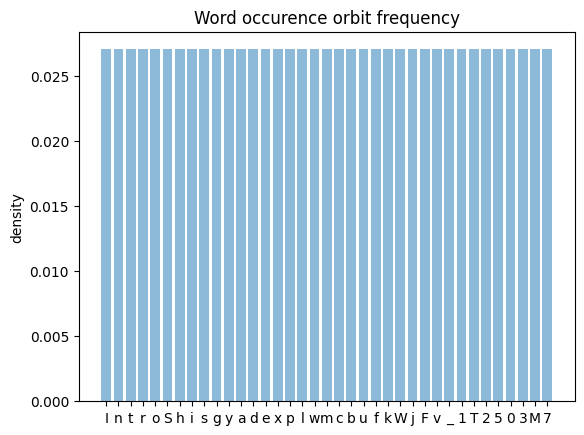

In [160]:
m = State(cleaned_intro)
uniform = State.from_uniform(m.states.keys())
print(uniform)
uniform.draw()

In our case we can sample this uniform distrubution easily becuase i've writen a method that does so. However in general this might not be possible. You may only have access to local information about the network at any time and be unable to sample from the full structure. One thing we could try is sampling an orbit: 

-------------------------------------------------------------------------------
t  :  0.10938  |  i  :  0.07319  |  m  :  0.01160  |  e  :  0.11778  |  s  :  0.08178  |  g  :  0.01860  |  
a  :  0.08518  |  l  :  0.04519  |  v  :  0.00680  |  n  :  0.07199  |  h  :  0.03679  |  2  :  0.00160  |  
5  :  0.00640  |  0  :  0.00680  |  T  :  0.00400  |  d  :  0.02500  |  p  :  0.03319  |  f  :  0.02020  |  
r  :  0.05739  |  u  :  0.01600  |  y  :  0.00640  |  x  :  0.00420  |  o  :  0.07059  |  w  :  0.01660  |  
b  :  0.01580  |  j  :  0.00260  |  _  :  0.00800  |  c  :  0.02160  |  3  :  0.00100  |  k  :  0.00960  |  
I  :  0.00520  |  7  :  0.00100  |  S  :  0.00460  |  F  :  0.00080  |  M  :  0.00120  |  W  :  0.00160  |  
1  :  0.00040  |  


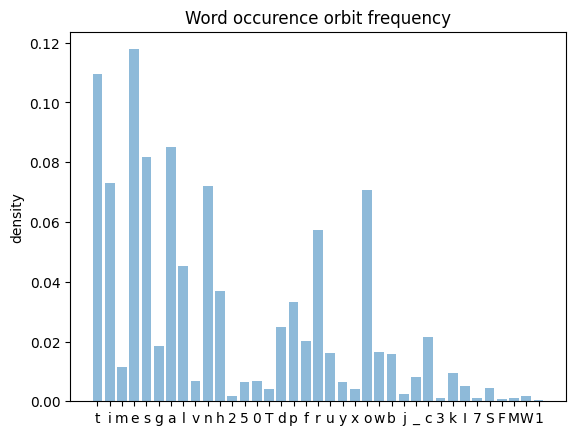

In [161]:
m = State(cleaned_intro)
T = TransitionMatrix(cleaned_intro)
w = Walker('t')
w.state
orbit = [w]

for i in range(5000):
    orbit.append(T@orbit[-1])

orbit_dist = State.from_orbit([o.state for o in orbit])
print(orbit_dist)
orbit_dist.draw()

So this cleary hasn't converged to a representative sample of the network as it's hevily biased towards certain nodes. Notice t,e and a come up alot but 1, 2 and 3 don't. We can take a look:

In [162]:
print('Num connections for t: ', len(T.p['t']))
print('Num connections for e: ', len(T.p['e']))
print('Num connections for a: ', len(T.p['a']))
print('\n whereas \n')
print('Num connections for t: ', len(T.p['1']))
print('Num connections for e: ', len(T.p['2']))
print('Num connections for a: ', len(T.p['3']))

Num connections for t:  19
Num connections for e:  23
Num connections for a:  18

 whereas 

Num connections for t:  2
Num connections for e:  2
Num connections for a:  3


## similarity of distrubutions:

___

We want a measure of similartity between distrubutions. To get this we just subract the two vectors from each other, sum the square of the differences and take the square root of the sum. 

$$dist(p_1, p_2) = \sqrt{\sum_{i=0}^{N}(p_1[i] - p_2[i])^2}$$

So for two equal distrubutions we get: 

In [163]:
uniform.dist(uniform)

0.0

and for two unequal distrubutions we have a value greater than zero:

In [165]:
orbit_dist.dist(uniform)

0.19812283676445708

this gives us a method for examining convergence.
    - For instance is it the case that two different orbits are converging to the same distrubution. 
    - And how does the orbit distrubution converge or not converge w.r.t. the uniform distrubution  
    
We can test this. The following graphs show how the orbit distrubutions of two random walks converge to each other but neither converge to the uniform distrubution:

**Note**: _This is not a fast way of doing this._

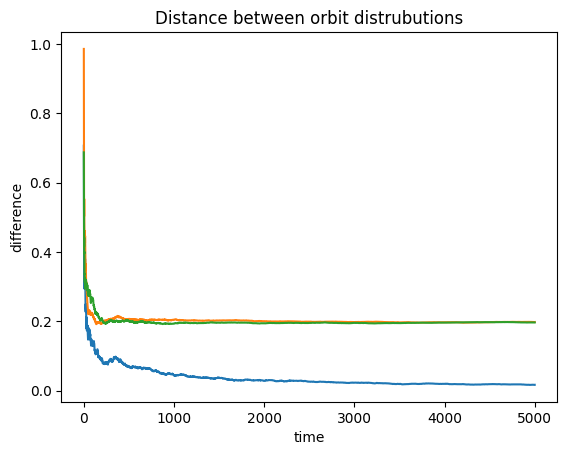

In [166]:
T = TransitionMatrix(cleaned_intro)
orbit_1 = [Walker('t')]
orbit_2 = [Walker('o')]
differences_1 = []
differences_2 = []
differences_3 = []

for i in range(5000):
    orbit_1.append(T@orbit_1[-1])
    orbit_2.append(T@orbit_2[-1])
    orbit_dist_1 = State.from_orbit([o.state for o in orbit_1])
    orbit_dist_2 = State.from_orbit([o.state for o in orbit_2])
    differences_1.append(orbit_dist_1.dist(orbit_dist_2))
    differences_2.append(orbit_dist_1.dist(uniform))
    differences_3.append(orbit_dist_2.dist(uniform))
    
plt.plot(differences_1)
plt.plot(differences_2)
plt.plot(differences_3)
plt.title('Distance between orbit distrubutions')
plt.ylabel('difference')
plt.xlabel('time')
plt.show()
